In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
n = 500

In [4]:
# Datos sintéticos
MedInc = np.random.lognormal(mean=2.5, sigma=0.35, size=n)
HouseAge = np.random.randint(low=1, high=52, size=n)
Longitude = -124 + np.random.rand(n) * 10
Latitude = 32 + np.random.rand(n) * 8
AveRooms = 5 + 0.15 * MedInc + 0.03 * HouseAge + np.random.randn(n)

# target
target = (
    0.45 * MedInc
    - 0.02 * HouseAge
    - 0.3 * (Latitude - 36)
    - 0.1 * (Longitude + 119)
    + 0.02 * AveRooms
    + np.random.randn(n) * 0.5
)

df = pd.DataFrame(
    {
        "MedInc": MedInc,
        "HouseAge": HouseAge,
        "Longitude": Longitude,
        "Latitude": Latitude,
        "AveRooms": AveRooms,
        "target": target,
    }
)

numeric_cols = df.columns.tolist()

In [6]:
cov_mat = df[numeric_cols].cov()
corr_mat = df[numeric_cols].corr()

print(f"Covariance matrix:\n{cov_mat.round(3)}")
print(f"\nCorrelation matrix:\n{corr_mat.round(3)}")

Covariance matrix:
           MedInc  HouseAge  Longitude  Latitude  AveRooms  target
MedInc     19.931    -1.536     -0.574     0.406     2.930   8.877
HouseAge   -1.536   216.932      1.925     0.528     5.777  -4.892
Longitude  -0.574     1.925      8.436    -0.110    -0.052  -1.176
Latitude    0.406     0.528     -0.110     4.886     0.210  -1.335
AveRooms    2.930     5.777     -0.052     0.210     1.568   1.175
target      8.877    -4.892     -1.176    -1.335     1.175   4.844

Correlation matrix:
           MedInc  HouseAge  Longitude  Latitude  AveRooms  target
MedInc      1.000    -0.023     -0.044     0.041     0.524   0.903
HouseAge   -0.023     1.000      0.045     0.016     0.313  -0.151
Longitude  -0.044     0.045      1.000    -0.017    -0.014  -0.184
Latitude    0.041     0.016     -0.017     1.000     0.076  -0.274
AveRooms    0.524     0.313     -0.014     0.076     1.000   0.426
target      0.903    -0.151     -0.184    -0.274     0.426   1.000


# **Hat Matrix**

In [21]:
X = df.drop("target", axis=1).values
y = df["target"].values.reshape(-1, 1)

In [25]:
XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
beta = XtX_inv @ X.T @ y
y_hat = X @ beta

In [26]:
resid = y - y_hat

In [29]:
H = X @ XtX_inv @ X.T
leverage = np.diag(H)

In [34]:
for x, name in zip([H, y, X, beta], ["H", "y", "X", "beta"]):
    print(f"\n{name} shape:{x.shape}\n")


H shape:(500, 500)


y shape:(500, 1)


X shape:(500, 5)


beta shape:(5, 1)



In [35]:
summary = pd.DataFrame({
    'index': np.arange(n),
    'leverage': leverage,
    'y': y.flatten(),
    'y_hat': y_hat.flatten(),
    'resid': resid.flatten(),
})

In [37]:
print("Top 10 Leverage Points")
print(summary.sort_values(by="leverage", ascending=False).head(10).round(3))

Top 10 Leverage Points
     index  leverage       y   y_hat  resid
229    229     0.043  12.196  12.943 -0.747
52      52     0.036  11.892  11.148  0.744
70      70     0.033  13.541  12.958  0.583
141    141     0.033   8.193   7.960  0.233
153    153     0.032  12.005  12.881 -0.876
38      38     0.031   9.988  10.122 -0.134
49      49     0.028  11.671  10.985  0.686
130    130     0.028   4.250   4.132  0.118
18      18     0.025  10.609  11.145 -0.536
152    152     0.025   7.336   6.932  0.405


In [38]:
n, p = X.shape
print("n:", n)
print("p:", p)

n: 500
p: 5


In [39]:
avg_lev = p/n
threshold = 2*avg_lev
print("Average Leverage:", avg_lev)
print("Threshold:", threshold)

Average Leverage: 0.01
Threshold: 0.02


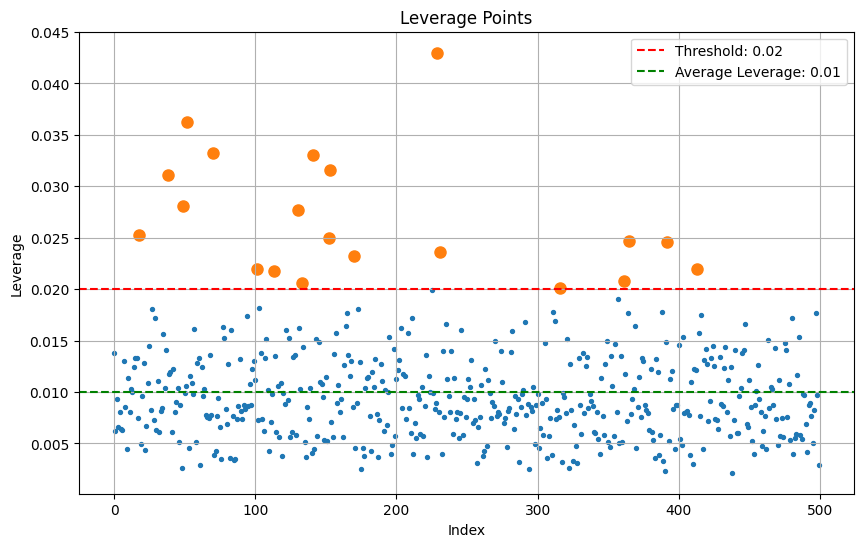

In [42]:
# Plotting leverage points
plt.figure(figsize=(10, 6))
plt.scatter(summary['index'], summary['leverage'], s=8)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.axhline(y=avg_lev, color='g', linestyle='--', label=f'Average Leverage: {avg_lev:.2f}')

hi_idx = summary[summary['leverage'] > threshold].index.tolist()

if len(hi_idx) > 0:
  plt.scatter(hi_idx, summary.loc[hi_idx, "leverage"], s=8*8)

plt.legend()
plt.xlabel('Index')
plt.ylabel('Leverage')
plt.title('Leverage Points')
plt.grid(True)
plt.show()